In [1]:
#!pip install munkres
#!pip install opencv-python

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
print(IN_COLAB)

True


In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('/content/drive/MyDrive/ColabNotebooks/2022_fall_bigdata/')

Mounted at /content/drive


# Object Keypoint Similarity (OKS) 구하기
: Compute oks between each detection and ground truth object

In [6]:
!pip install munkres

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import math
import cv2
import munkres
import numpy as np
import io
import skimage.io as io
import json
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [12]:
dataDir='./data/annotations_trainval2017'
loc = '{}/annotations/'.format(dataDir)

## COCO dataset (val2017) : 정답
https://cocodataset.org/#download 에서 제공하는 2017 Train/Val annotations 를 사용

In [15]:
dataType='val2017'
annFile='{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)
print(annFile)

./data/annotations_trainval2017/annotations/person_keypoints_val2017.json


In [16]:
#annFile = './person_keypoints_val2017.json'
#annFile = './person_keypoints_val2017_small2.json' # 많은 부분 제거한 version. 다른 이미지는 동작 X
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=1.72s)
creating index...
index created!


* 예제에 사용될 id 를 골라서 이미지를 그려본다.

In [17]:
imgIds = [157928]

In [18]:
img = coco_kps.loadImgs(imgIds)[0]

In [19]:
img

{'license': 2,
 'file_name': '000000157928.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000157928.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-19 21:30:39',
 'flickr_url': 'http://farm8.staticflickr.com/7013/6787196535_776c956d40_z.jpg',
 'id': 157928}

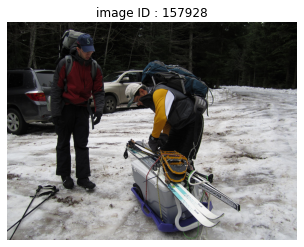

In [20]:
image = io.imread(img['coco_url'])
plt.axis('off')
plt.title('image ID : {}'.format(img['id']))
plt.imshow(image)
plt.show()

### 해당 이미지에서 사람 관련된 부분만 가져오기

In [21]:
catIds = coco_kps.getCatIds(catNms=['person'])
print("category ID ... ", catIds)

category ID ...  [1]


In [22]:
annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco_kps.loadAnns(annIds)

In [23]:
print(len(anns))

2


### Annotation 한 개 선택해서 bbox, keypoints 그려보기
v = 0 , not labled <br>
v = 1 , labeled but not visible <br>
v = 2 , labeled and visiable

In [24]:
# anns[0]['keypoints']

In [25]:
person_id = 0

In [26]:
gt_keypoint = anns[person_id]['keypoints']
gx = gt_keypoint[0::3]
gy = gt_keypoint[1::3]
visability = gt_keypoint[2::3]
print("X : {}\nY : {}\nV :{}".format(gx, gy, visability))

X : [181, 185, 172, 0, 157, 192, 128, 203, 107, 203, 108, 167, 130, 165, 124, 165, 127]
Y : [73, 64, 64, 0, 60, 102, 97, 152, 151, 197, 205, 202, 200, 271, 270, 341, 336]
V :[2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [27]:
gt_area = anns[person_id]['area']
gt_bbox = anns[person_id]['bbox']
print('gt_bbox : {}\ngt_area: {}'.format(gt_bbox, gt_area))

gt_bbox : [94.05, 24.86, 122.17, 341.63]
gt_area: 26100.764


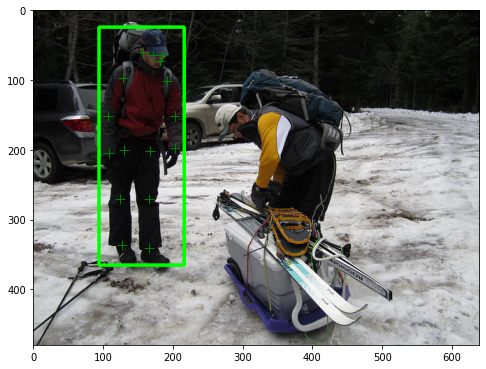

In [28]:
fig=plt.figure(figsize=(8,8))
image = io.imread(img['coco_url'])
cv2.rectangle(image, 
              (int(gt_bbox[0]), int(gt_bbox[1])),
              (int(gt_bbox[0])+int(gt_bbox[2]), int(gt_bbox[1])+int(gt_bbox[3])),
              (0,255,0), 4)
plt.plot(gx, gy, 'g+', markersize=10)
plt.imshow(image)
plt.show()

### 모두 그려보기

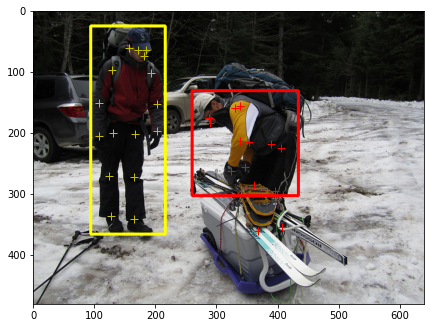

In [29]:
fig=plt.figure(figsize=(7,7))
image = io.imread(img['coco_url'])
colors = [(255,255,0), (255,0,0)]
colors2 = [ 'y+', 'r+']
for i, ann in enumerate(anns):
    cv2.rectangle(image, 
                  (int(ann['bbox'][0]), int(ann['bbox'][1])),
                  (int(ann['bbox'][0])+int(ann['bbox'][2]), int(ann['bbox'][1])+int(ann['bbox'][3])),
                  colors[i], 4)
    plt.plot(ann['keypoints'][0::3], ann['keypoints'][1::3], colors2[i], markersize=8)
plt.imshow(image)
plt.show()

## 추론 가져오기

HRNet 이용, https://github.com/HRNet

In [32]:
pred_fn = './data/output_000000157928.json'

In [33]:
with open(pred_fn) as json_file:
    pred_anns = json.load(json_file)

In [34]:
pred_anns

{'0': [[[21, 35, 279, 380], [269, 98, 447, 334]],
  [[[70.9375, 182.25, 0.952401340007782],
    [63.75, 185.8333282470703, 0.9688028693199158],
    [63.75, 175.0833282470703, 0.9505072236061096],
    [60.15625, 189.4166717529297, 0.8667314648628235],
    [60.15625, 157.1666717529297, 0.9586001634597778],
    [103.28125, 193.0, 0.8654504418373108],
    [92.5, 128.5, 0.8731942772865295],
    [153.59375, 203.75, 0.9261300563812256],
    [146.40625, 107.0, 0.8611308932304382],
    [196.71875, 203.75, 0.9245190024375916],
    [200.3125, 107.0, 0.8678671717643738],
    [193.125, 167.9166717529297, 0.8629050254821777],
    [189.53125, 128.5, 0.7868853807449341],
    [272.1875, 164.3333282470703, 0.8751214146614075],
    [268.59375, 124.91666412353516, 0.871096670627594],
    [344.0625, 167.9166717529297, 0.8895381689071655],
    [336.875, 128.5, 0.8539630174636841]],
   [[181.5833282470703, 291.25, 0.9374799728393555],
    [174.2083282470703, 286.3055419921875, 0.9465235471725464],
    [179.1

In [35]:
pred_anns = pred_anns['0']

In [36]:
len(pred_anns)

2

* bbox : Bounding box

In [37]:
pred_anns[0]

[[21, 35, 279, 380], [269, 98, 447, 334]]

In [38]:
dt_bbox = pred_anns[0][0]

* keypoints

In [39]:
len(pred_anns[1])

2

In [40]:
dt_keypoint =  np.array(pred_anns[1][0]).reshape(-1)

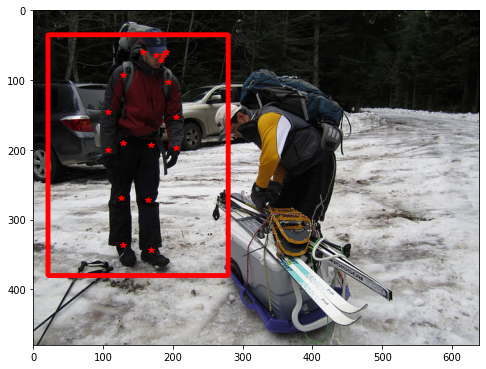

In [41]:
fig=plt.figure(figsize=(8,8))
image = io.imread(img['coco_url'])
cv2.rectangle(image, 
              (int(dt_bbox[0]), int(dt_bbox[1])),
              (int(dt_bbox[2]), int(dt_bbox[3])),
              (255,0,0), 5)
plt.plot(dt_keypoint[1::3], dt_keypoint[0::3], 'r*', markersize=6)
plt.imshow(image)
plt.show()

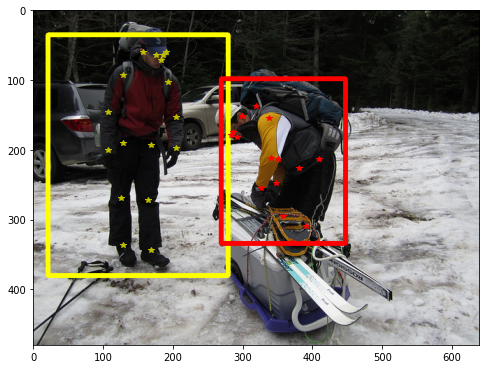

In [42]:
fig=plt.figure(figsize=(8,8))
image = io.imread(img['coco_url'])
colors = [(255,255,0), (255,0,0)]
colors3 = [ 'y*', 'r*']
for ann in pred_anns:
    for i, dt in enumerate(ann):
        if len(dt) == 4: # bbox
            cv2.rectangle(image, 
                          (int(dt[0]), int(dt[1])),
                          (int(dt[2]), int(dt[3])),
                          colors[i%2], 5)
        elif len(dt) == 17 : # keypoints
            dt = np.array(dt).reshape(-1)
            plt.plot(dt[1::3], dt[0::3], colors3[i%2], markersize=6)
plt.imshow(image)
plt.show()

## OKS 계산하기

$$ \Large OKS = \Sigma_{i}{[exp(\frac{-d^2_i}{2s^2k^2_i}\delta(v_i > 0)]/\Sigma_{i}[\delta(v_{i}>0)]}$$

- $d_i$ : Ground Truth keypoint 와 검출된 keypoint 사이의 Euclidean distance
- $v_i$ : Ground Truth 의 visibility flag ( 검출기의 예측된 $v_i$ 는 사용하지 X )
- $s$  : 객체 세그먼트 영역의 제곱근
- $k_i$ :  falloff 를 제어하는 keypoint 마다 존재하는 상수 (a per-keypoint constant that controls falloff)

레이블에 있는 모든 keypoint ( $v_i$ > 0 ) 에 대해 평균을 구한다. 

레이블링 되어있지 않는 예측 keypoint 는 OKS 에 영향을 미치지 않는다. 

ex ) 검출기가 왼쪽 손목의 keypoint 를 예측해서 결과가 나왔어도 왼쪽 손목이 레이블링 되어있지 않는다면 OKS 는 계산되지 않고 결과에 영향을 미치지 않는다. 

예측이 완벽하면 OKS = 1, 정답과 예측의 사이가 작을 수록 OKS 값이 1에 가까워진다.

객체 scale $s$ 에 대한 keypoint 당 표준편차 $\sigma_i$ 를 보면 $\sigma$ 값은 keypoint 에 따라 크게 달라진다.

어깨, 무릎, 엉덩이 등이 머리에 있는 눈,코,귀보다 훨씬 큰 $\sigma$를 갖는 경향이 있다.

To put it simply, OKS plays the same role that IoU plays in object detection. It is calculated from the distance between predicted points and ground truth points normalized by the scale of the person.

아래는 pycocotools/cocoeval.py#L523 에서 가져온 부분 https://github.com/cocodataset/cocoapi/blob/8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9/PythonAPI/pycocotools/cocoeval.py#L523

In [43]:
kpt_oks_sigmas = np.array(
    [.26, .25, .25, .35, .35, .79, .79, .72, .72, .62,.62, 1.07, 1.07, .87, .87, .89, .89])/10.0
sigmas = kpt_oks_sigmas
vars = (sigmas * 2)**2
k = len(sigmas)
print('k={}'.format(k))

k=17


### Compute oks between each detection and ground truth object
**한 명의 Annotation에 대한 OKS 구해보기**

In [44]:
dt_bbox1 = pred_anns [0][0]
dt_keypoint1 = pred_anns[1][0]

In [45]:
dt_keypoint1

[[70.9375, 182.25, 0.952401340007782],
 [63.75, 185.8333282470703, 0.9688028693199158],
 [63.75, 175.0833282470703, 0.9505072236061096],
 [60.15625, 189.4166717529297, 0.8667314648628235],
 [60.15625, 157.1666717529297, 0.9586001634597778],
 [103.28125, 193.0, 0.8654504418373108],
 [92.5, 128.5, 0.8731942772865295],
 [153.59375, 203.75, 0.9261300563812256],
 [146.40625, 107.0, 0.8611308932304382],
 [196.71875, 203.75, 0.9245190024375916],
 [200.3125, 107.0, 0.8678671717643738],
 [193.125, 167.9166717529297, 0.8629050254821777],
 [189.53125, 128.5, 0.7868853807449341],
 [272.1875, 164.3333282470703, 0.8751214146614075],
 [268.59375, 124.91666412353516, 0.871096670627594],
 [344.0625, 167.9166717529297, 0.8895381689071655],
 [336.875, 128.5, 0.8539630174636841]]

아래 OKS 계산식은 cocoeval.py#L213-L232 에서 가져옴 

https://github.com/cocodataset/cocoapi/blob/8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9/PythonAPI/pycocotools/cocoeval.py#L213-L232

$ OKS = \large \Sigma_{i}{[exp(\frac{-d^2_i}{2s^2k^2_i}\delta(v_i > 0)]/\Sigma_{i}[\delta(v_{i}>0)]}$

### Ground truth object

In [46]:
# create bounds for ignore regions(double the gt bbox)
g = np.array(anns[0]['keypoints'])
xg = g[0::3]; yg = g[1::3]; vg = g[2::3]
print("xg shape {} {}\nyg shape {} {}\nvg shape {} {}\n".format(
    xg.shape, xg, yg.shape,yg, vg.shape,vg))

xg shape (17,) [181 185 172   0 157 192 128 203 107 203 108 167 130 165 124 165 127]
yg shape (17,) [ 73  64  64   0  60 102  97 152 151 197 205 202 200 271 270 341 336]
vg shape (17,) [2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2]



### Prediction

In [51]:
bb = anns[0]['bbox']

x0 = bb[0] - bb[2]; x1 = bb[0] + bb[2] * 2
y0 = bb[1] - bb[3]; y1 = bb[1] + bb[3] * 2

d = np.array(dt_keypoint1).reshape(-1)
xd = d[1::3]; yd = d[0::3]
print("xd shape {} {}\nyd shape {} {}\n".format(
    xd.shape, xd, yd.shape, yd))

xd shape (17,) [182.25       185.83332825 175.08332825 189.41667175 157.16667175
 193.         128.5        203.75       107.         203.75
 107.         167.91667175 128.5        164.33332825 124.91666412
 167.91667175 128.5       ]
yd shape (17,) [ 70.9375   63.75     63.75     60.15625  60.15625 103.28125  92.5
 153.59375 146.40625 196.71875 200.3125  193.125   189.53125 272.1875
 268.59375 344.0625  336.875  ]



### GT의 Visiblity 에 따른 거리 계산

In [52]:
k1 = np.count_nonzero(vg > 0)
print(k1)

16


In [53]:
k

17

In [54]:
if k1>0:
    # measure the per-keypoint distance if keypoints visible
    dx = xd - xg
    dy = yd - yg
else:
    # measure minimum distance to keypoints in (x0,y0) & (x1,y1)
    z = np.zeros((k))
    dx = np.max((z, x0-xd),axis=0)+np.max((z, xd-x1),axis=0)
    dy = np.max((z, y0-yd),axis=0)+np.max((z, yd-y1),axis=0)

$ OKS = \large \Sigma_{i}{[exp(\frac{-d^2_i}{2s^2k^2_i}\delta(v_i > 0)]/\Sigma_{i}[\delta(v_{i}>0)]}$

In [55]:
e = (dx**2 + dy**2) / vars / (anns[0]['area']+np.spacing(1)) / 2

In [56]:
e

array([4.12064148e-02, 5.80010583e-03, 7.33266894e-02, 1.54415098e+02,
       2.04050387e-04, 2.02707549e-03, 1.57310051e-02, 2.86621694e-03,
       1.94951470e-02, 7.99353401e-04, 2.86209884e-02, 3.32992583e-02,
       4.67847971e-02, 1.17346541e-03, 1.78291373e-03, 1.08140183e-02,
       1.82328314e-03])

In [57]:
vg > 0

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [58]:
if k1 > 0:
    e=e[vg > 0] # GT의 Visibility 처리
    
print('\ne >> ',e)


e >>  [0.04120641 0.00580011 0.07332669 0.00020405 0.00202708 0.01573101
 0.00286622 0.01949515 0.00079935 0.02862099 0.03329926 0.0467848
 0.00117347 0.00178291 0.01081402 0.00182328]


In [59]:
oks = np.sum(np.exp(-e)) / e.shape[0]
print('\nOKS >> ',oks)


OKS >>  0.9825084666744025


OKS 값은 1에 가까울 수록 정확한 예측이라고 판단한다.<br>
계산된 OKS가 0.98 로 예측 결과가 좋은 것을 확인할 수 있다.

## References

* A 2019 guide to Human Pose Estimation with Deep Learning https://nanonets.com/blog/human-pose-estimation-2d-guide/
* COCO and Places Visual Recognition Challenges Workshop ICCV 2017, http://presentations.cocodataset.org/COCO17-Keypoints-Overview.pdf